# Calculation of the cross attention

---

In [11]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn.metrics as metrics
import seaborn as sns
sns.set_theme()

from os import path

from training_bert import BertNliLight
from custom_data_set import SnliDataset
from custom_data_set import test_dir, dev_dir
from torch.utils.data import DataLoader

from attention_algorithms.attention_metrics import default_plot_colormap
from attention_algorithms.attention_metrics import cross_attention_score

# set the repository to the git repository
cwd = os.getcwd().split(os.path.sep)
while cwd[-1] != "stage_4_gm":
    os.chdir("..")
    cwd = os.getcwd().split(os.path.sep)
print(">> the git rep : ", end="")
print(os.getcwd())

# the folder where we will save our data
plots_folder = os.path.join(os.getcwd(), '.cache', 'plots')
graph_folder = path.join(plots_folder, "cross_attention")
if not path.exists(path.join(plots_folder, "cross_attention")):
    os.mkdir(path.join(plots_folder, "cross_attention"))

print(f">> the plots location : {graph_folder}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
>> the git rep : C:\Users\loicf\Documents\IRISA\stage_4_gm\stage_4_gm
>> the plots location : C:\Users\loicf\Documents\IRISA\stage_4_gm\stage_4_gm\.cache\plots\cross_attention


In [2]:
# load the model

ckp = path.join(".cache", "logs", "igrida_trained", "0", "best.ckpt")
model = BertNliLight.load_from_checkpoint(ckp)
model.eval()  # make sure to have the model in eval mod before using it

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertNliLight(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)

In [3]:
# load the data
data_set = SnliDataset(dir=test_dir, nb_sentences=1000, msg=False)
data_loader = DataLoader(data_set, batch_size=1000, shuffle=False)

sentences, masks, train_labels = next(iter(data_loader))

In [4]:
# the data we annotated.
e_snli_data = pd.read_csv(os.path.join('.cache', 'raw_data', 'e_snli', 'cleaned_data', 'test.csv'), sep=",")\
    [["tok_sent", "hg_goal", "label"]]
e_snli_data.head()

,tok_sent,hg_goal,label
0,"['[CLS]', 'this', 'church', 'choir', 'sings', ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",neutral
1,"['[CLS]', 'this', 'church', 'choir', 'sings', ...","[0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...",entailment
2,"['[CLS]', 'this', 'church', 'choir', 'sings', ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",contradiction
3,"['[CLS]', 'a', 'woman', 'with', 'a', 'green', ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",neutral
4,"['[CLS]', 'a', 'woman', 'with', 'a', 'green', ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",entailment


In [5]:
pur_attention, Y_test, _ = cross_attention_score(sentences=sentences, masks=masks,
                                                 e_snli_data=e_snli_data,
                                                 model=model)

>> start the calculus for 1000 sentences


100%|██████████| 1000/1000 [04:00<00:00,  4.16it/s]

>> nb_errors : 21
>> len Y_test : 26600


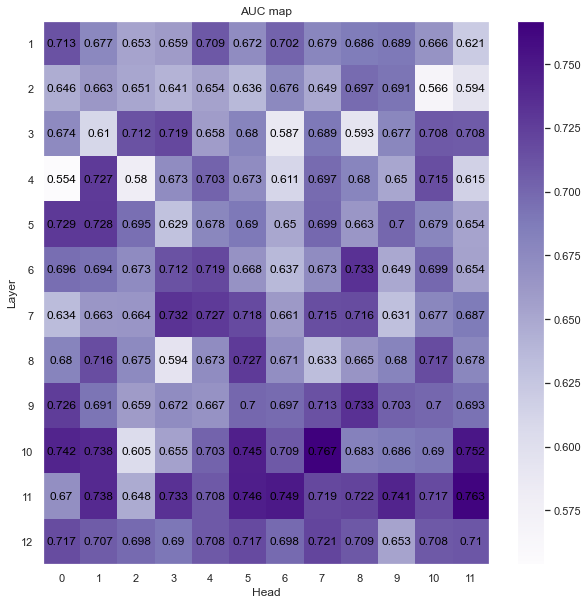

In [6]:
# Construction of the AUC map
auc_map = np.zeros((12, 12))
for l in range(12):
    for h in range(12):
        preds = pur_attention[f"layer_{l}"][f"head_{h}"]
        fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
        auc_map[l, h] = metrics.auc(fpr, tpr)

# plot the color map
fig = default_plot_colormap(auc_map, xlabel="Head", ylabel="Layer", title="AUC map")
plt.savefig(os.path.join(graph_folder, "auc_map.png"))
plt.show()